# ResNet

<div style="display: flex; align-items: center;">
    <img src="../imgs/ResNet.jpg" alt="Your Image" width="500" style="margin-right: 20px;">
    <div>
        <p>From experience, the depth of the network is crucial to the performance of the model. When the number of network layers is increased, the network can extract more complex feature patterns, so theoretically, better results can be achieved when the model is deeper. But will deeper networks necessarily have better performance? As the depth of the network increases, the accuracy of the network saturates or even decreases.
</p>
        <p>The degradation problem of deep networks at least indicates that deep networks are not easy to train. Residual learning solves the problem of difficult training and even degradation of networks, making it easier to learn the original features directly compared to residual learning. When the residual is 0, the stacked layer only performs identity mapping, at least the network performance will not decrease. In fact, the residual will not be 0, which will enable the stacked layer to learn new features based on the input features, thus having better performance. This is somewhat similar to a "short circuit" in a circuit, so it is a short circuit connection.</p>
        <p>In this chapter, we will introduce the ResNet model and a new challenge, which is the CIFAR10 dataset.</p>
    </div>
</div>

## ResNet

In [1]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self, input_channels, num_classes, zero_init_residual=False, groups=1, width_per_group=64):
        super(ResNet, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1

        self.groups = groups
        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(input_channels, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.blocks_layer = nn.Sequential(
            self._make_layer(BasicBlock, 64, 2),
            self._make_layer(BasicBlock, 128, 2, stride=2, dilate=False),
            self._make_layer(BasicBlock, 256, 2, stride=2, dilate=False),
            self._make_layer(BasicBlock, 512, 2, stride=2, dilate=False)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self._initialize_weights(zero_init_residual)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups, base_width=self.base_width, dilation=self.dilation, norm_layer=norm_layer))
        return nn.Sequential(*layers)

    def _initialize_weights(self, zero_init_residual):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.blocks_layer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

D:\Anaconda\envs\bdl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\bdl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
D:\Anaconda\envs\bdl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# CIFAR10

The CIFAR-10 dataset is a widely used benchmark dataset in the field of machine learning and computer vision. It is well-suited for training machine learning algorithms and evaluating their performance. Here’s a detailed overview of the CIFAR-10 dataset:

- **number of classes**: 10.
- **classes**: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.
- **number of images**: 50000 images for train, 10000 images for test.
- **image size**: 32x32 pixels.
- **Color**: Each image is in RGB (color).

## Train ResNet on CIFAR10

In [2]:
import sys
import torch.nn as nn
sys.path.append('../tools')
from CIFAR10 import cifar10_trainer

Files already downloaded and verified
2024-05-24 13:28:59
Epoch 1 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.02it/s, val_acc=23.4, val_loss=0.0166]


Validation loss decreased (inf --> 0.016592).
2024-05-24 13:30:04
Epoch 2 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.68it/s, val_acc=25.6, val_loss=0.0159]


Validation loss decreased (0.016592 --> 0.015862).
2024-05-24 13:31:08
Epoch 3 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  6.18it/s, val_acc=27.7, val_loss=0.0157]


Validation loss decreased (0.015862 --> 0.015667).
2024-05-24 13:32:20
Epoch 4 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  6.30it/s, val_acc=34.2, val_loss=0.0145]


Validation loss decreased (0.015667 --> 0.014540).
2024-05-24 13:33:36
Epoch 5 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:06<00:00,  6.20it/s, val_acc=36.9, val_loss=0.014]


Validation loss decreased (0.014540 --> 0.014035).
2024-05-24 13:34:53
Epoch 6 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  5.95it/s, val_acc=37.3, val_loss=0.0139]


Validation loss decreased (0.014035 --> 0.013893).
2024-05-24 13:36:13
Epoch 7 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  5.91it/s, val_acc=45.3, val_loss=0.0125]


Validation loss decreased (0.013893 --> 0.012532).
2024-05-24 13:37:33
Epoch 8 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  6.97it/s, val_acc=44.2, val_loss=0.0131]


2024-05-24 13:38:45
Epoch 9 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.13it/s, val_acc=45.7, val_loss=0.0124]


Validation loss decreased (0.012532 --> 0.012360).
2024-05-24 13:39:53
Epoch 10 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  6.21it/s, val_acc=48.5, val_loss=0.0119]


Validation loss decreased (0.012360 --> 0.011906).
2024-05-24 13:41:07
Epoch 11 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  6.98it/s, val_acc=45.1, val_loss=0.0126]


2024-05-24 13:42:21
Epoch 12 / 200


[Valid]: 100%|█████████████████████████| 40/40 [00:05<00:00,  7.31it/s, val_acc=50, val_loss=0.0118]


Validation loss decreased (0.011906 --> 0.011778).
2024-05-24 13:43:26
Epoch 13 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.19it/s, val_acc=53.3, val_loss=0.0107]


Validation loss decreased (0.011778 --> 0.010676).
2024-05-24 13:44:32
Epoch 14 / 200


[Valid]: 100%|█████████████████████████| 40/40 [00:05<00:00,  7.37it/s, val_acc=48, val_loss=0.0119]


2024-05-24 13:45:38
Epoch 15 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=43.2, val_loss=0.0136]


2024-05-24 13:46:45
Epoch 16 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.36it/s, val_acc=53.1, val_loss=0.0109]


2024-05-24 13:47:51
Epoch 17 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:06<00:00,  6.10it/s, val_acc=51.9, val_loss=0.011]


2024-05-24 13:49:04
Epoch 18 / 200


[Valid]: 100%|██████████████████████████| 40/40 [00:06<00:00,  6.07it/s, val_acc=52, val_loss=0.011]


2024-05-24 13:50:21
Epoch 19 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  6.37it/s, val_acc=51.8, val_loss=0.0112]


2024-05-24 13:51:37
Epoch 20 / 200


[Valid]: 100%|█████████████████████████| 40/40 [00:06<00:00,  6.19it/s, val_acc=52, val_loss=0.0112]


2024-05-24 13:52:53
Epoch 21 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  6.05it/s, val_acc=51.6, val_loss=0.0113]


2024-05-24 13:54:09
Epoch 22 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.29it/s, val_acc=51.5, val_loss=0.0114]


2024-05-24 13:55:20
Epoch 23 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  6.07it/s, val_acc=53.3, val_loss=0.0112]


2024-05-24 13:56:31
Epoch 24 / 200
lr is updated to 0.05


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.86it/s, val_acc=58.7, val_loss=0.00964]


Validation loss decreased (0.010676 --> 0.009637).
2024-05-24 13:57:49
Epoch 25 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.97it/s, val_acc=60.6, val_loss=0.00916]


Validation loss decreased (0.009637 --> 0.009163).
2024-05-24 13:59:06
Epoch 26 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.15it/s, val_acc=62.2, val_loss=0.00893]


Validation loss decreased (0.009163 --> 0.008926).
2024-05-24 14:00:24
Epoch 27 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.23it/s, val_acc=60.5, val_loss=0.00934]


2024-05-24 14:01:40
Epoch 28 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  6.11it/s, val_acc=62.3, val_loss=0.0088]


Validation loss decreased (0.008926 --> 0.008796).
2024-05-24 14:02:57
Epoch 29 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.93it/s, val_acc=61.2, val_loss=0.00903]


2024-05-24 14:04:14
Epoch 30 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.96it/s, val_acc=58.4, val_loss=0.00975]


2024-05-24 14:05:31
Epoch 31 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.99it/s, val_acc=60.8, val_loss=0.00914]


2024-05-24 14:06:48
Epoch 32 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.04it/s, val_acc=58.6, val_loss=0.00964]


2024-05-24 14:08:05
Epoch 33 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.15it/s, val_acc=60.9, val_loss=0.00893]


2024-05-24 14:09:22
Epoch 34 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.02it/s, val_acc=58.4, val_loss=0.00947]


2024-05-24 14:10:38
Epoch 35 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.36it/s, val_acc=63.3, val_loss=0.00832]


Validation loss decreased (0.008796 --> 0.008319).
2024-05-24 14:11:48
Epoch 36 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.42it/s, val_acc=59.6, val_loss=0.00952]


2024-05-24 14:12:54
Epoch 37 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.04it/s, val_acc=63.9, val_loss=0.00843]


2024-05-24 14:14:08
Epoch 38 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.08it/s, val_acc=62.8, val_loss=0.00895]


2024-05-24 14:15:26
Epoch 39 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.06it/s, val_acc=64.6, val_loss=0.00813]


Validation loss decreased (0.008319 --> 0.008132).
2024-05-24 14:16:44
Epoch 40 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.81it/s, val_acc=60.6, val_loss=0.00876]


2024-05-24 14:18:03
Epoch 41 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  6.08it/s, val_acc=62.6, val_loss=0.0087]


2024-05-24 14:19:22
Epoch 42 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.85it/s, val_acc=60.3, val_loss=0.00918]


2024-05-24 14:20:40
Epoch 43 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=63.7, val_loss=0.00843]


2024-05-24 14:21:47
Epoch 44 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.23it/s, val_acc=65.2, val_loss=0.00802]


Validation loss decreased (0.008132 --> 0.008020).
2024-05-24 14:22:53
Epoch 45 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  7.10it/s, val_acc=64, val_loss=0.00835]


2024-05-24 14:24:01
Epoch 46 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.04it/s, val_acc=64.8, val_loss=0.0083]


2024-05-24 14:25:08
Epoch 47 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.97it/s, val_acc=60.7, val_loss=0.00939]


2024-05-24 14:26:18
Epoch 48 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.16it/s, val_acc=60.9, val_loss=0.0091]


2024-05-24 14:27:26
Epoch 49 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.15it/s, val_acc=64.3, val_loss=0.00842]


2024-05-24 14:28:32
Epoch 50 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.12it/s, val_acc=61.4, val_loss=0.00905]


2024-05-24 14:29:40
Epoch 51 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.18it/s, val_acc=65.5, val_loss=0.00805]


2024-05-24 14:30:48
Epoch 52 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.20it/s, val_acc=64.7, val_loss=0.00836]


2024-05-24 14:32:03
Epoch 53 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.65it/s, val_acc=65.8, val_loss=0.00789]


Validation loss decreased (0.008020 --> 0.007893).
2024-05-24 14:33:23
Epoch 54 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.55it/s, val_acc=65.7, val_loss=0.00792]


2024-05-24 14:34:46
Epoch 55 / 200


[Valid]: 100%|█████████████████████████| 40/40 [00:07<00:00,  5.46it/s, val_acc=63, val_loss=0.0086]


2024-05-24 14:36:08
Epoch 56 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.11it/s, val_acc=64.6, val_loss=0.00806]


2024-05-24 14:37:35
Epoch 57 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.55it/s, val_acc=65.1, val_loss=0.00809]


2024-05-24 14:38:59
Epoch 58 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.60it/s, val_acc=63.8, val_loss=0.00832]


2024-05-24 14:40:23
Epoch 59 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.04it/s, val_acc=65.2, val_loss=0.00805]


2024-05-24 14:41:45
Epoch 60 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.05it/s, val_acc=64.8, val_loss=0.00818]


2024-05-24 14:43:12
Epoch 61 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.33it/s, val_acc=63.6, val_loss=0.00812]


2024-05-24 14:44:41
Epoch 62 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.64it/s, val_acc=64.4, val_loss=0.00828]


2024-05-24 14:46:03
Epoch 63 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.97it/s, val_acc=61.1, val_loss=0.00931]


2024-05-24 14:47:23
Epoch 64 / 200
lr is updated to 0.025


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.09it/s, val_acc=70.5, val_loss=0.00694]


Validation loss decreased (0.007893 --> 0.006938).
2024-05-24 14:48:40
Epoch 65 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  6.83it/s, val_acc=70.6, val_loss=0.0068]


Validation loss decreased (0.006938 --> 0.006798).
2024-05-24 14:49:49
Epoch 66 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=70.9, val_loss=0.0068]


2024-05-24 14:50:57
Epoch 67 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.96it/s, val_acc=69.8, val_loss=0.00711]


2024-05-24 14:52:06
Epoch 68 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.07it/s, val_acc=68.8, val_loss=0.00732]


2024-05-24 14:53:15
Epoch 69 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.02it/s, val_acc=69.9, val_loss=0.00696]


2024-05-24 14:54:23
Epoch 70 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.97it/s, val_acc=70.3, val_loss=0.00689]


2024-05-24 14:55:32
Epoch 71 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.15it/s, val_acc=68.5, val_loss=0.00735]


2024-05-24 14:56:39
Epoch 72 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.27it/s, val_acc=70.4, val_loss=0.00708]


2024-05-24 14:57:47
Epoch 73 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.17it/s, val_acc=69.7, val_loss=0.00694]


2024-05-24 14:58:55
Epoch 74 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.04it/s, val_acc=69.6, val_loss=0.00713]


2024-05-24 15:00:03
Epoch 75 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.07it/s, val_acc=69.9, val_loss=0.00693]


2024-05-24 15:01:12
Epoch 76 / 200
lr is updated to 0.0125


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.22it/s, val_acc=74.3, val_loss=0.00594]


Validation loss decreased (0.006798 --> 0.005943).
2024-05-24 15:02:19
Epoch 77 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.12it/s, val_acc=75.3, val_loss=0.00579]


Validation loss decreased (0.005943 --> 0.005791).
2024-05-24 15:03:27
Epoch 78 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.25it/s, val_acc=74.4, val_loss=0.00593]


2024-05-24 15:04:42
Epoch 79 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:07<00:00,  5.23it/s, val_acc=74.8, val_loss=0.006]


2024-05-24 15:06:21
Epoch 80 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:13<00:00,  2.91it/s, val_acc=75.4, val_loss=0.00574]


Validation loss decreased (0.005791 --> 0.005735).
2024-05-24 15:08:23
Epoch 81 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:08<00:00,  4.46it/s, val_acc=74, val_loss=0.00623]


2024-05-24 15:12:05
Epoch 82 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:22<00:00,  1.76it/s, val_acc=74.5, val_loss=0.00609]


2024-05-24 15:20:00
Epoch 83 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:09<00:00,  4.24it/s, val_acc=72.4, val_loss=0.00639]


2024-05-24 15:23:15
Epoch 84 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:13<00:00,  2.97it/s, val_acc=74.6, val_loss=0.00601]


2024-05-24 15:31:19
Epoch 85 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:06<00:00,  5.83it/s, val_acc=74, val_loss=0.00602]


2024-05-24 15:34:23
Epoch 86 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.94it/s, val_acc=74.6, val_loss=0.00569]


Validation loss decreased (0.005735 --> 0.005691).
2024-05-24 15:35:35
Epoch 87 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.97it/s, val_acc=73.8, val_loss=0.00606]


2024-05-24 15:36:45
Epoch 88 / 200


[Valid]: 100%|█████████████████████████| 40/40 [00:07<00:00,  5.11it/s, val_acc=74, val_loss=0.0059]


2024-05-24 15:38:02
Epoch 89 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.75it/s, val_acc=74.5, val_loss=0.00595]


2024-05-24 15:39:16
Epoch 90 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  6.73it/s, val_acc=73.3, val_loss=0.006]


2024-05-24 15:40:32
Epoch 91 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.83it/s, val_acc=72.8, val_loss=0.00625]


2024-05-24 15:41:46
Epoch 92 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.70it/s, val_acc=74.1, val_loss=0.00615]


2024-05-24 15:43:03
Epoch 93 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.87it/s, val_acc=72.7, val_loss=0.00628]


2024-05-24 15:44:17
Epoch 94 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:06<00:00,  5.79it/s, val_acc=73.4, val_loss=0.0061]


2024-05-24 15:45:34
Epoch 95 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.10it/s, val_acc=74.2, val_loss=0.00615]


2024-05-24 15:47:28
Epoch 96 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.09it/s, val_acc=73.4, val_loss=0.00618]


2024-05-24 15:49:24
Epoch 97 / 200
lr is updated to 0.00625


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.66it/s, val_acc=77.4, val_loss=0.00535]


Validation loss decreased (0.005691 --> 0.005347).
2024-05-24 15:51:21
Epoch 98 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.03it/s, val_acc=76.9, val_loss=0.00533]


Validation loss decreased (0.005347 --> 0.005331).
2024-05-24 15:53:24
Epoch 99 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.98it/s, val_acc=76.7, val_loss=0.0055]


2024-05-24 15:55:35
Epoch 100 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.44it/s, val_acc=77.1, val_loss=0.00519]


Validation loss decreased (0.005331 --> 0.005188).
2024-05-24 15:57:41
Epoch 101 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.59it/s, val_acc=76.6, val_loss=0.00549]


2024-05-24 15:59:56
Epoch 102 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.47it/s, val_acc=77.7, val_loss=0.00529]


2024-05-24 16:02:28
Epoch 103 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:09<00:00,  4.38it/s, val_acc=76.5, val_loss=0.00539]


2024-05-24 16:05:05
Epoch 104 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:10<00:00,  3.80it/s, val_acc=78, val_loss=0.00517]


Validation loss decreased (0.005188 --> 0.005175).
2024-05-24 16:07:58
Epoch 105 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:11<00:00,  3.48it/s, val_acc=77.1, val_loss=0.00524]


2024-05-24 16:11:00
Epoch 106 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.77it/s, val_acc=77.6, val_loss=0.00539]


2024-05-24 16:13:23
Epoch 107 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.06it/s, val_acc=77.5, val_loss=0.00526]


2024-05-24 16:14:44
Epoch 108 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.46it/s, val_acc=77.5, val_loss=0.00524]


2024-05-24 16:16:02
Epoch 109 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.73it/s, val_acc=77.8, val_loss=0.00506]


Validation loss decreased (0.005175 --> 0.005060).
2024-05-24 16:17:18
Epoch 110 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.35it/s, val_acc=76.5, val_loss=0.00567]


2024-05-24 16:18:37
Epoch 111 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.98it/s, val_acc=76.9, val_loss=0.00542]


2024-05-24 16:20:45
Epoch 112 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.66it/s, val_acc=77.5, val_loss=0.00531]


2024-05-24 16:22:47
Epoch 113 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:08<00:00,  4.95it/s, val_acc=76, val_loss=0.00549]


2024-05-24 16:24:50
Epoch 114 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:07<00:00,  5.06it/s, val_acc=76.9, val_loss=0.0053]


2024-05-24 16:26:45
Epoch 115 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.83it/s, val_acc=77.2, val_loss=0.0054]


2024-05-24 16:28:47
Epoch 116 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:07<00:00,  5.11it/s, val_acc=77.2, val_loss=0.00538]


2024-05-24 16:30:46
Epoch 117 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.55it/s, val_acc=76.8, val_loss=0.00539]


2024-05-24 16:32:47
Epoch 118 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:09<00:00,  4.39it/s, val_acc=77.3, val_loss=0.00516]


2024-05-24 16:35:00
Epoch 119 / 200


[Valid]: 100%|█████████████████████████| 40/40 [00:07<00:00,  5.00it/s, val_acc=77, val_loss=0.0055]


2024-05-24 16:37:07
Epoch 120 / 200
lr is updated to 0.003125


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.62it/s, val_acc=78.4, val_loss=0.00518]


2024-05-24 16:39:18
Epoch 121 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.61it/s, val_acc=78.7, val_loss=0.00476]


Validation loss decreased (0.005060 --> 0.004760).
2024-05-24 16:42:06
Epoch 122 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:09<00:00,  4.21it/s, val_acc=80, val_loss=0.00476]


Validation loss decreased (0.004760 --> 0.004759).
2024-05-24 16:44:40
Epoch 123 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.97it/s, val_acc=78.7, val_loss=0.00494]


2024-05-24 16:47:17
Epoch 124 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.41it/s, val_acc=78.4, val_loss=0.00492]


2024-05-24 16:48:34
Epoch 125 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.88it/s, val_acc=79.1, val_loss=0.00476]


2024-05-24 16:49:52
Epoch 126 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  5.94it/s, val_acc=79.5, val_loss=0.00472]


Validation loss decreased (0.004759 --> 0.004717).
2024-05-24 16:51:27
Epoch 127 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:09<00:00,  4.25it/s, val_acc=78.8, val_loss=0.00497]


2024-05-24 16:53:52
Epoch 128 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:09<00:00,  4.05it/s, val_acc=79.4, val_loss=0.00475]


2024-05-24 16:56:38
Epoch 129 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:09<00:00,  4.30it/s, val_acc=80.3, val_loss=0.00456]


Validation loss decreased (0.004717 --> 0.004560).
2024-05-24 16:59:43
Epoch 130 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:10<00:00,  3.91it/s, val_acc=79.1, val_loss=0.00505]


2024-05-24 17:02:16
Epoch 131 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:09<00:00,  4.38it/s, val_acc=79.6, val_loss=0.00471]


2024-05-24 17:04:43
Epoch 132 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.97it/s, val_acc=79.9, val_loss=0.00479]


2024-05-24 17:06:54
Epoch 133 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:08<00:00,  4.62it/s, val_acc=79.2, val_loss=0.00484]


2024-05-24 17:09:12
Epoch 134 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:10<00:00,  3.95it/s, val_acc=79.5, val_loss=0.00471]


2024-05-24 17:11:22
Epoch 135 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.42it/s, val_acc=79.3, val_loss=0.00478]


2024-05-24 17:13:19
Epoch 136 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.82it/s, val_acc=78.9, val_loss=0.00493]


2024-05-24 17:14:32
Epoch 137 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.97it/s, val_acc=80.4, val_loss=0.00457]


2024-05-24 17:15:42
Epoch 138 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  6.80it/s, val_acc=80, val_loss=0.00464]


2024-05-24 17:16:51
Epoch 139 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.18it/s, val_acc=79.4, val_loss=0.00489]


2024-05-24 17:18:00
Epoch 140 / 200
lr is updated to 0.0015625


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.05it/s, val_acc=81.4, val_loss=0.00451]


Validation loss decreased (0.004560 --> 0.004511).
2024-05-24 17:19:08
Epoch 141 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.79it/s, val_acc=80.7, val_loss=0.00445]


Validation loss decreased (0.004511 --> 0.004451).
2024-05-24 17:20:16
Epoch 142 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.77it/s, val_acc=81.2, val_loss=0.00457]


2024-05-24 17:21:24
Epoch 143 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=80.7, val_loss=0.00434]


Validation loss decreased (0.004451 --> 0.004339).
2024-05-24 17:22:32
Epoch 144 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.16it/s, val_acc=80.7, val_loss=0.00449]


2024-05-24 17:23:40
Epoch 145 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.00it/s, val_acc=81.2, val_loss=0.00439]


2024-05-24 17:24:48
Epoch 146 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.09it/s, val_acc=81.3, val_loss=0.00444]


2024-05-24 17:25:56
Epoch 147 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=81.8, val_loss=0.00433]


Validation loss decreased (0.004339 --> 0.004328).
2024-05-24 17:27:04
Epoch 148 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  6.82it/s, val_acc=81, val_loss=0.00447]


2024-05-24 17:28:12
Epoch 149 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.96it/s, val_acc=80.9, val_loss=0.00452]


2024-05-24 17:29:20
Epoch 150 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.95it/s, val_acc=81.3, val_loss=0.00449]


2024-05-24 17:30:29
Epoch 151 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=80.4, val_loss=0.00449]


2024-05-24 17:31:37
Epoch 152 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.10it/s, val_acc=81.3, val_loss=0.00447]


2024-05-24 17:32:45
Epoch 153 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.05it/s, val_acc=80.6, val_loss=0.00452]


2024-05-24 17:33:53
Epoch 154 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.82it/s, val_acc=81.1, val_loss=0.00448]


2024-05-24 17:35:03
Epoch 155 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.99it/s, val_acc=80.6, val_loss=0.00465]


2024-05-24 17:36:11
Epoch 156 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.91it/s, val_acc=80.8, val_loss=0.00459]


2024-05-24 17:37:20
Epoch 157 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.99it/s, val_acc=81.1, val_loss=0.00434]


2024-05-24 17:38:29
Epoch 158 / 200
lr is updated to 0.00078125


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.71it/s, val_acc=82.2, val_loss=0.00424]


Validation loss decreased (0.004328 --> 0.004241).
2024-05-24 17:39:38
Epoch 159 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.15it/s, val_acc=82.1, val_loss=0.00416]


Validation loss decreased (0.004241 --> 0.004159).
2024-05-24 17:40:46
Epoch 160 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=82.2, val_loss=0.00419]


2024-05-24 17:41:54
Epoch 161 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  6.93it/s, val_acc=82.3, val_loss=0.0043]


2024-05-24 17:43:03
Epoch 162 / 200


[Valid]: 100%|█████████████████████████| 40/40 [00:05<00:00,  6.98it/s, val_acc=82, val_loss=0.0044]


2024-05-24 17:44:11
Epoch 163 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.02it/s, val_acc=82.2, val_loss=0.00418]


2024-05-24 17:45:20
Epoch 164 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  7.05it/s, val_acc=81, val_loss=0.00427]


2024-05-24 17:46:28
Epoch 165 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.14it/s, val_acc=82.2, val_loss=0.00425]


2024-05-24 17:47:37
Epoch 166 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=81.9, val_loss=0.00445]


2024-05-24 17:48:46
Epoch 167 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=81.9, val_loss=0.00425]


2024-05-24 17:49:54
Epoch 168 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.10it/s, val_acc=81.9, val_loss=0.00447]


2024-05-24 17:51:02
Epoch 169 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.04it/s, val_acc=82.2, val_loss=0.00417]


2024-05-24 17:52:10
Epoch 170 / 200
lr is updated to 0.000390625


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.06it/s, val_acc=82.9, val_loss=0.00406]


Validation loss decreased (0.004159 --> 0.004056).
2024-05-24 17:53:18
Epoch 171 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.20it/s, val_acc=82.3, val_loss=0.00408]


2024-05-24 17:54:25
Epoch 172 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.94it/s, val_acc=82.1, val_loss=0.00432]


2024-05-24 17:55:32
Epoch 173 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.93it/s, val_acc=81.8, val_loss=0.00412]


2024-05-24 17:56:41
Epoch 174 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  6.88it/s, val_acc=83, val_loss=0.00392]


Validation loss decreased (0.004056 --> 0.003919).
2024-05-24 17:57:49
Epoch 175 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.10it/s, val_acc=81.8, val_loss=0.00419]


2024-05-24 17:58:58
Epoch 176 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.91it/s, val_acc=82.5, val_loss=0.00401]


2024-05-24 18:00:07
Epoch 177 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  6.79it/s, val_acc=82.7, val_loss=0.004]


2024-05-24 18:01:16
Epoch 178 / 200


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  6.97it/s, val_acc=82.3, val_loss=0.0042]


2024-05-24 18:02:25
Epoch 179 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.74it/s, val_acc=83.4, val_loss=0.00404]


2024-05-24 18:03:34
Epoch 180 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.00it/s, val_acc=81.7, val_loss=0.00415]


2024-05-24 18:04:44
Epoch 181 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.78it/s, val_acc=82.8, val_loss=0.00398]


2024-05-24 18:05:54
Epoch 182 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.91it/s, val_acc=81.4, val_loss=0.00422]


2024-05-24 18:07:03
Epoch 183 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.97it/s, val_acc=82.9, val_loss=0.00422]


2024-05-24 18:08:12
Epoch 184 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  7.04it/s, val_acc=82.6, val_loss=0.00402]


2024-05-24 18:09:21
Epoch 185 / 200
lr is updated to 0.0001953125


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.78it/s, val_acc=82.1, val_loss=0.00419]


2024-05-24 18:10:31
Epoch 186 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.92it/s, val_acc=82.8, val_loss=0.00403]


2024-05-24 18:11:41
Epoch 187 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:06<00:00,  6.54it/s, val_acc=83, val_loss=0.00412]


2024-05-24 18:12:50
Epoch 188 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  6.75it/s, val_acc=83, val_loss=0.00414]


2024-05-24 18:14:00
Epoch 189 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:05<00:00,  6.87it/s, val_acc=82, val_loss=0.00427]


2024-05-24 18:15:10
Epoch 190 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.76it/s, val_acc=83.1, val_loss=0.00388]


Validation loss decreased (0.003919 --> 0.003878).
2024-05-24 18:16:20
Epoch 191 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.90it/s, val_acc=82.8, val_loss=0.00416]


2024-05-24 18:17:30
Epoch 192 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.77it/s, val_acc=82.8, val_loss=0.00399]


2024-05-24 18:18:39
Epoch 193 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.74it/s, val_acc=83.2, val_loss=0.00386]


Validation loss decreased (0.003878 --> 0.003861).
2024-05-24 18:19:50
Epoch 194 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.73it/s, val_acc=82.2, val_loss=0.00421]


2024-05-24 18:21:00
Epoch 195 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.96it/s, val_acc=82.9, val_loss=0.00397]


2024-05-24 18:22:10
Epoch 196 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.70it/s, val_acc=82.5, val_loss=0.00413]


2024-05-24 18:23:21
Epoch 197 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.74it/s, val_acc=82.2, val_loss=0.00429]


2024-05-24 18:24:32
Epoch 198 / 200


[Valid]: 100%|████████████████████████| 40/40 [00:06<00:00,  6.57it/s, val_acc=83, val_loss=0.00415]


2024-05-24 18:25:44
Epoch 199 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:06<00:00,  6.33it/s, val_acc=82.2, val_loss=0.00429]


2024-05-24 18:26:56
Epoch 200 / 200


[Valid]: 100%|██████████████████████| 40/40 [00:05<00:00,  6.93it/s, val_acc=83.3, val_loss=0.00384]


Validation loss decreased (0.003861 --> 0.003839).


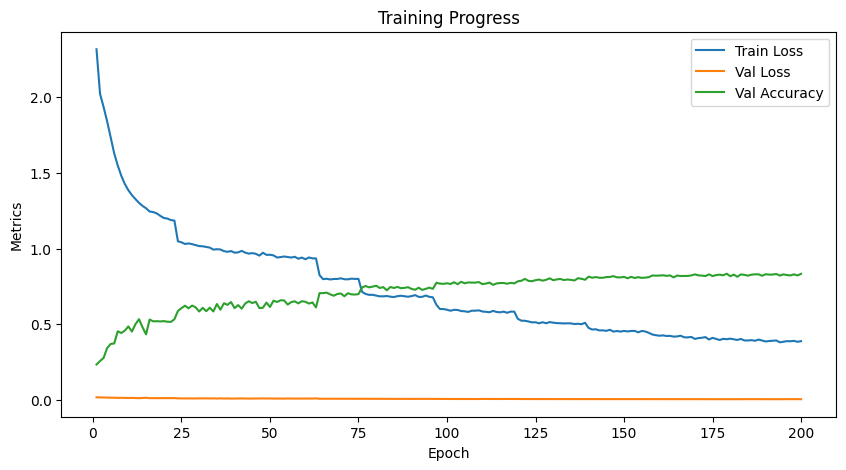

Testing [Test]: 100%|████████████████████████| 79/79 [00:05<00:00, 14.95it/s, test_acc=94.5, test_loss=0.00131]


In [4]:
from torchvision.transforms import autoaugment, transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)),
    transforms.RandomHorizontalFlip(),
    autoaugment.AutoAugment(policy=autoaugment.AutoAugmentPolicy('cifar10')),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


model = ResNet(input_channels=3, num_classes=10)
trainer = cifar10_trainer(model=model, lr=0.1, batch_size=128, epoch=200, train_transforms=train_transforms, test_transforms=test_transforms)
trainer.train()
trainer.test()